# DimABSA Track A - Subtask 2: Dimensional Aspect Sentiment Triplet Extraction (DimASTE)

## Obiettivo
Dato un testo, estrarre tutti i **triplet (Aspect, Opinion, VA)** dove:
- **Aspect**: termine che indica l'aspetto target
- **Opinion**: termine che esprime il sentiment
- **VA**: punteggio Valence-Arousal (V#A) con valori da 1.00 a 9.00

## Pipeline
1. **Estrazione Aspect/Opinion**: Uso di LLM (LLAMA) con prompt engineering
2. **Predizione VA**: Modello encoder (BERT multilingua) per predire i valori continui

---

## 1. Setup e Import Librerie

In [2]:
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    BitsAndBytesConfig,
    pipeline,
    AutoModel
)

# PyTorch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Set seed per riproducibilità
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## 2. Analisi del Dataset

In [6]:
def load_jsonl_from_url(url: str) -> List[Dict]:
    """
    Carica dati JSONL da un URL GitHub.

    Args:
        url: URL del file JSONL

    Returns:
        Lista di dizionari
    """
    import urllib.request

    try:
        print(f"⏳ Caricamento da {url.split('/')[-1]}...")
        with urllib.request.urlopen(url) as response:
            data = response.read().decode('utf-8')
            items = [json.loads(line) for line in data.strip().split('\n') if line.strip()]
        print(f"✓ Caricati {len(items)} esempi")
        return items
    except Exception as e:
        print(f"❌ Errore nel caricamento da {url}: {e}")
        raise

# Caricamento dati
train_data = load_jsonl_from_url(TRAIN_URL)
print(f"\n{'='*60}")
print(f"DATASET CARICATO")
print(f"{'='*60}")
print(f"Numero di esempi nel training set: {len(train_data)}")
print(f"\nEsempio di dato:")
print(json.dumps(train_data[0], indent=2))


⏳ Caricamento da eng_restaurant_train_alltasks.jsonl...
✓ Caricati 2284 esempi

DATASET CARICATO
Numero di esempi nel training set: 2284

Esempio di dato:
{
  "ID": "rest16_quad_dev_1",
  "Text": "ca n ' t wait wait for my next visit .",
  "Quadruplet": [
    {
      "Aspect": "NULL",
      "Opinion": "NULL",
      "Category": "RESTAURANT#GENERAL",
      "VA": "6.75#6.38"
    }
  ]
}


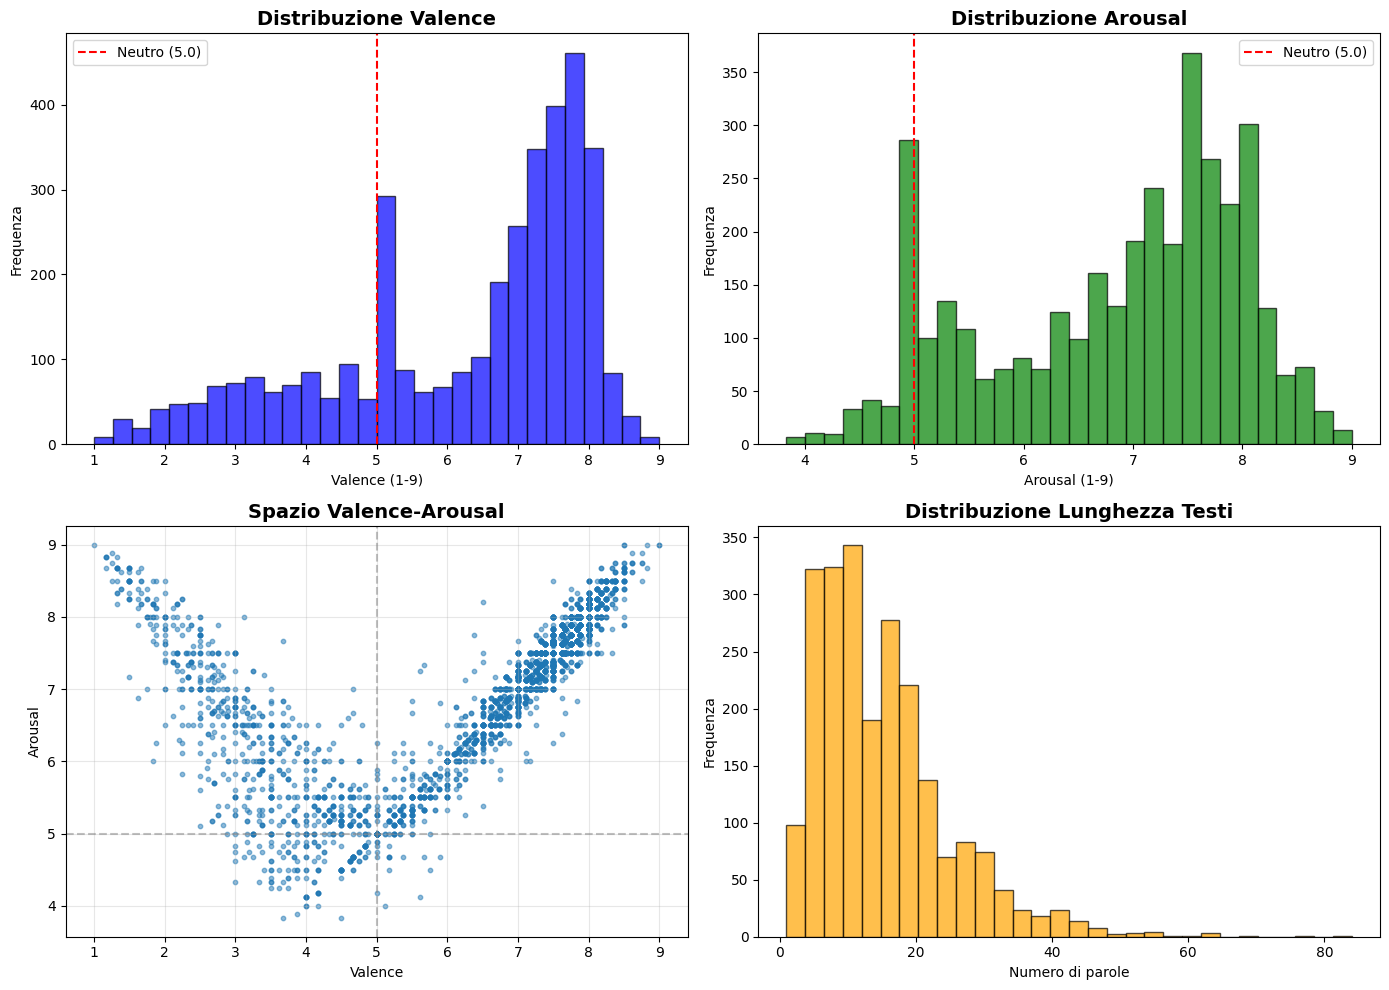

In [8]:
# Visualizzazioni
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribuzione Valence
axes[0, 0].hist(train_stats['valence_values'], bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribuzione Valence', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Valence (1-9)')
axes[0, 0].set_ylabel('Frequenza')
axes[0, 0].axvline(5.0, color='red', linestyle='--', label='Neutro (5.0)')
axes[0, 0].legend()

# Distribuzione Arousal
axes[0, 1].hist(train_stats['arousal_values'], bins=30, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribuzione Arousal', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Arousal (1-9)')
axes[0, 1].set_ylabel('Frequenza')
axes[0, 1].axvline(5.0, color='red', linestyle='--', label='Neutro (5.0)')
axes[0, 1].legend()

# Scatter plot VA
axes[1, 0].scatter(train_stats['valence_values'], train_stats['arousal_values'],
                   alpha=0.5, s=10)
axes[1, 0].set_title('Spazio Valence-Arousal', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Valence')
axes[1, 0].set_ylabel('Arousal')
axes[1, 0].axhline(5.0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].axvline(5.0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

# Distribuzione lunghezza testi
axes[1, 1].hist(train_stats['text_lengths'], bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Distribuzione Lunghezza Testi', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Numero di parole')
axes[1, 1].set_ylabel('Frequenza')

plt.tight_layout()
plt.show()

In [9]:
def convert_to_triplets(data: List[Dict]) -> List[Dict]:
    """Converte i Quadruplet in Triplet per Subtask 2."""
    converted_data = []

    for item in data:
        new_item = {
            'ID': item['ID'],
            'Text': item['Text'],
            'Triplet': []
        }

        # Se il dataset ha già Quadruplet, convertiamo
        quads = item.get('Quadruplet', item.get('Triplet', []))

        for quad in quads:
            triplet = {
                'Aspect': quad['Aspect'],
                'Opinion': quad['Opinion'],
                'VA': quad['VA']
            }
            new_item['Triplet'].append(triplet)

        converted_data.append(new_item)

    return converted_data

# Conversione dei dati
train_triplets = convert_to_triplets(train_data)
print(f"Dati convertiti in formato Triplet")
print(f"\nEsempio dopo conversione:")
print(json.dumps(train_triplets[2], indent=2))

Dati convertiti in formato Triplet

Esempio dopo conversione:
{
  "ID": "rest16_quad_dev_3",
  "Text": "the spicy tuna roll was unusually good and the rock shrimp tempura was awesome , great appetizer to share !",
  "Triplet": [
    {
      "Aspect": "spicy tuna roll",
      "Opinion": "unusually good",
      "VA": "7.50#7.62"
    },
    {
      "Aspect": "rock shrimp tempura",
      "Opinion": "awesome",
      "VA": "8.25#8.38"
    }
  ]
}


In [10]:
@dataclass
class TripletExample:
    """Classe per rappresentare un esempio di triplet."""
    id: str
    text: str
    triplets: List[Dict[str, str]]

class DimABSADataset(Dataset):
    """Dataset personalizzato per DimABSA Subtask 2."""

    def __init__(self, data: List[Dict]):
        self.examples = []

        for item in data:
            example = TripletExample(
                id=item['ID'],
                text=item['Text'],
                triplets=item['Triplet']
            )
            self.examples.append(example)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]

# Creazione dataset
train_dataset = DimABSADataset(train_triplets)
print(f"\nDataset creato con {len(train_dataset)} esempi")
print(f"\nEsempio dal dataset:")
example = train_dataset[2]
print(f"ID: {example.id}")
print(f"Text: {example.text}")
print(f"Triplets: {example.triplets}")


Dataset creato con 2284 esempi

Esempio dal dataset:
ID: rest16_quad_dev_3
Text: the spicy tuna roll was unusually good and the rock shrimp tempura was awesome , great appetizer to share !
Triplets: [{'Aspect': 'spicy tuna roll', 'Opinion': 'unusually good', 'VA': '7.50#7.62'}, {'Aspect': 'rock shrimp tempura', 'Opinion': 'awesome', 'VA': '8.25#8.38'}]


In [ ]:
class AspectOpinionExtractor:
    """Estrattore di Aspect e Opinion usando LLM."""

    def __init__(self, model_name: str = "meta-llama/Llama-3.2-3B-Instruct"):
        """
        Inizializza l'estrattore.

        Args:
            model_name: Nome del modello HuggingFace da utilizzare
        """
        print(f"Caricamento del modello {model_name}...")

        # Carica tokenizer e modello (senza quantizzazione)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,  # Usa float16 per efficienza
            device_map="auto",
            trust_remote_code=True
        )

        # Set pad token
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        print("Modello caricato con successo!")

    def create_prompt(self, text: str) -> str:
        """Crea il prompt few-shot per l'estrazione."""
        prompt = f"""You are an aspect-opinion extraction system. Your task is to extract aspect-opinion pairs and return them as valid JSON.

RULES:
1. ASPECT = target entity or attribute (e.g., "food", "service", "price")
2. OPINION = sentiment expression about the aspect (e.g., "delicious", "terrible")
3. Use "NULL" if aspect or opinion is implicit
4. Return ONLY valid JSON array, no additional text
5. Do NOT add explanations, notes, or any text before/after the JSON

FORMAT REQUIREMENT:
- Output must be ONLY a JSON array: [{{"aspect": "...", "opinion": "..."}}, ...]
- Do NOT wrap in markdown code blocks
- Do NOT add any text before or after the JSON array

EXAMPLES:

Text: "The food was delicious but the service was slow."
[{{"aspect": "food", "opinion": "delicious"}}, {{"aspect": "service", "opinion": "slow"}}]

Text: "Great atmosphere and amazing cocktails!"
[{{"aspect": "atmosphere", "opinion": "Great"}}, {{"aspect": "cocktails", "opinion": "amazing"}}]

Text: "Overpriced and disappointing."
[{{"aspect": "NULL", "opinion": "Overpriced"}}, {{"aspect": "NULL", "opinion": "disappointing"}}]

Text: "{text}"
"""
        return prompt

    def extract(self, text: str, max_new_tokens: int = 256) -> List[Dict[str, str]]:
        """Estrae aspect e opinion dal testo con parsing JSON robusto."""
        prompt = self.create_prompt(text)

        # Tokenizza
        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

        # Genera
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                temperature=0.1,
                do_sample=True,
                top_p=0.95,
                pad_token_id=self.tokenizer.pad_token_id
            )

        # Decodifica
        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        # PARSING JSON ROBUSTO
        try:
            # Step 1: Estrai la parte dopo il prompt (la risposta del modello)
            # Il prompt termina con 'Text: "{text}"\n', quindi cerchiamo dopo questo
            split_marker = f'Text: "{text}"'
            if split_marker in response:
                json_str = response.split(split_marker)[-1].strip()
            else:
                json_str = response.strip()

            # Step 2: Rimuovi markdown code blocks se presenti
            json_str = json_str.replace('```json', '').replace('```', '').strip()

            # Step 3: Rimuovi eventuali label "Output:" o simili
            for prefix in ['Output:', 'output:', 'Result:', 'result:', 'Answer:', 'answer:']:
                if json_str.startswith(prefix):
                    json_str = json_str[len(prefix):].strip()

            # Step 4: Estrazione bracket-aware (trova il JSON array)
            import re
            
            # Cerca l'inizio di un array JSON
            start_idx = json_str.find('[')
            if start_idx == -1:
                raise ValueError("No JSON array found in response")

            # Trova la chiusura corrispondente contando le parentesi
            bracket_count = 0
            end_idx = -1
            for i in range(start_idx, len(json_str)):
                if json_str[i] == '[':
                    bracket_count += 1
                elif json_str[i] == ']':
                    bracket_count -= 1
                    if bracket_count == 0:
                        end_idx = i + 1
                        break

            if end_idx == -1:
                # Fallback: usa regex per estrarre il JSON
                match = re.search(r'\[\s*\{.*?\}\s*\]', json_str, re.DOTALL)
                if match:
                    json_str = match.group(0)
                else:
                    raise ValueError("Could not find complete JSON array")
            else:
                json_str = json_str[start_idx:end_idx]

            # Step 5: Pulizia finale
            json_str = json_str.strip()

            # Step 6: Parse del JSON
            result = json.loads(json_str)

            # Step 7: Normalizza il formato
            if isinstance(result, list) and len(result) > 0:
                normalized = []
                for item in result:
                    if isinstance(item, dict):
                        normalized.append({
                            'Aspect': item.get('aspect', item.get('Aspect', 'NULL')),
                            'Opinion': item.get('opinion', item.get('Opinion', 'NULL'))
                        })
                return normalized if normalized else [{'Aspect': 'NULL', 'Opinion': 'NULL'}]
            else:
                return [{'Aspect': 'NULL', 'Opinion': 'NULL'}]

        except json.JSONDecodeError as e:
            print(f"⚠ JSON parsing error: {e}")
            print(f"  Response excerpt: ...{response[-200:]}")
            return [{'Aspect': 'NULL', 'Opinion': 'NULL'}]
        except Exception as e:
            print(f"⚠ Extraction error for text: '{text[:50]}...'")
            print(f"  Error: {e}")
            print(f"  Response excerpt: ...{response[-200:]}")
            return [{'Aspect': 'NULL', 'Opinion': 'NULL'}]

print("\nNOTA: L'estrazione con LLM richiede una GPU con almeno 6GB di VRAM per Llama-3.2-3B.")
print("Assicurati di aver configurato il token HuggingFace nella cella iniziale.")



NOTA: L'estrazione con LLM richiede una GPU con almeno 6GB di VRAM per Llama-3.2-3B.
Assicurati di aver configurato il token HuggingFace nella cella iniziale.


In [12]:
class VADataset(Dataset):
    """Dataset per il training del modello VA."""

    def __init__(self, data: List[Dict], tokenizer, max_length: int = 128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Prepara gli esempi
        self.examples = []
        for item in data:
            text = item['Text']
            for triplet in item['Triplet']:
                aspect = triplet['Aspect']
                opinion = triplet['Opinion']
                va = triplet['VA'].split('#')
                valence = float(va[0])
                arousal = float(va[1])

                # Crea input concatenato: [Text] [SEP] [Aspect] [SEP] [Opinion]
                input_text = f"{text} [SEP] {aspect} [SEP] {opinion}"

                self.examples.append({
                    'input_text': input_text,
                    'valence': valence,
                    'arousal': arousal
                })

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]

        # Estrai aspect, opinion e text dall'input_text memorizzato
        # Format atteso: "{text} [SEP] {aspect} [SEP] {opinion}"
        parts = example['input_text'].split(' [SEP] ')
        if len(parts) == 3:
            text, aspect, opinion = parts
            # Tokenizza con formato BERT a due segmenti:
            # [CLS] aspect: X; opinion: Y [SEP] text [SEP]
            encoding = self.tokenizer(
                f"aspect: {aspect}; opinion: {opinion}",  # Segmento A
                text,  # Segmento B
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
        else:
            # Fallback se formato non riconosciuto
            encoding = self.tokenizer(
                example['input_text'],
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'valence': torch.tensor(example['valence'], dtype=torch.float),
            'arousal': torch.tensor(example['arousal'], dtype=torch.float)
        }

print("Dataset VA definito.")

Dataset VA definito.


## 7. Training del Modello VA

In [15]:
# Inizializza modello
model = VAPredictor(encoder_name=ENCODER_NAME).to(device)

# Optimizer e loss
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

print(f"Modello inizializzato con {sum(p.numel() for p in model.parameters()):,} parametri")

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Modello inizializzato con 178,050,818 parametri


In [17]:
# Training loop
print("\n" + "="*50)
print("INIZIO TRAINING")
print("="*50)

history = {
    'train_loss': [],
    'val_loss': [],
    'val_rmse': []
}

best_val_rmse = float('inf')

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 50)

    # Training
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

    # Validation
    val_loss, val_rmse, _, _ = evaluate(model, val_loader, criterion, device)

    # Salva metriche
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_rmse'].append(val_rmse)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val RMSE (VA): {val_rmse:.4f}")

    # Salva miglior modello
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), 'best_va_model.pt')
        print(f"✓ Nuovo miglior modello salvato! (RMSE: {val_rmse:.4f})")

print("\n" + "="*50)
print("TRAINING COMPLETATO")
print("="*50)
print(f"Miglior RMSE (VA): {best_val_rmse:.4f}")


INIZIO TRAINING

Epoch 1/5
--------------------------------------------------


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 1.4476
Val Loss: 0.9316
Val RMSE (VA): 0.9503
✓ Nuovo miglior modello salvato! (RMSE: 0.9503)

Epoch 2/5
--------------------------------------------------


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.6313
Val Loss: 0.7838
Val RMSE (VA): 0.8733
✓ Nuovo miglior modello salvato! (RMSE: 0.8733)

Epoch 3/5
--------------------------------------------------


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.4308
Val Loss: 0.7139
Val RMSE (VA): 0.8360
✓ Nuovo miglior modello salvato! (RMSE: 0.8360)

Epoch 4/5
--------------------------------------------------


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.3398
Val Loss: 0.6507
Val RMSE (VA): 0.7991
✓ Nuovo miglior modello salvato! (RMSE: 0.7991)

Epoch 5/5
--------------------------------------------------


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.2911
Val Loss: 0.6176
Val RMSE (VA): 0.7790
✓ Nuovo miglior modello salvato! (RMSE: 0.7790)

TRAINING COMPLETATO
Miglior RMSE (VA): 0.7790


## 8. Valutazione Dettagliata

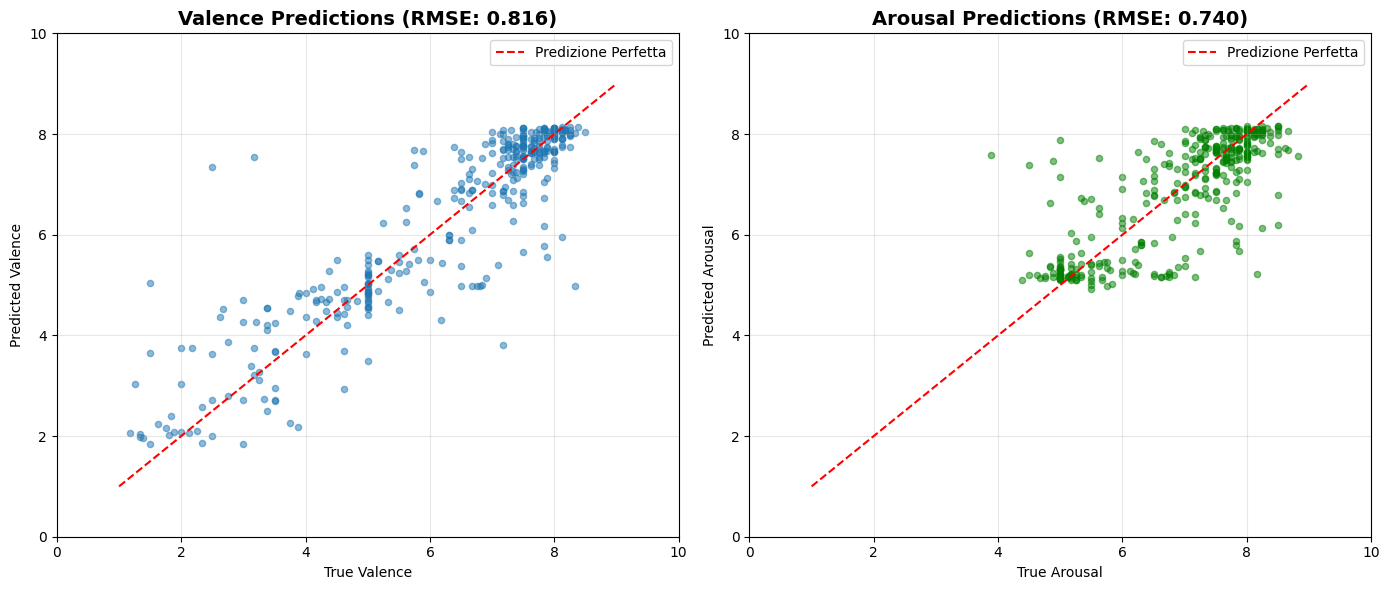

In [20]:
# Visualizzazioni predizioni vs target
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Valence
axes[0].scatter(true_valence, pred_valence, alpha=0.5, s=20)
axes[0].plot([1, 9], [1, 9], 'r--', label='Predizione Perfetta')
axes[0].set_title(f'Valence Predictions (RMSE: {rmse_valence:.3f})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('True Valence')
axes[0].set_ylabel('Predicted Valence')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 10)
axes[0].set_ylim(0, 10)

# Arousal
axes[1].scatter(true_arousal, pred_arousal, alpha=0.5, s=20, color='green')
axes[1].plot([1, 9], [1, 9], 'r--', label='Predizione Perfetta')
axes[1].set_title(f'Arousal Predictions (RMSE: {rmse_arousal:.3f})', fontsize=14, fontweight='bold')
axes[1].set_xlabel('True Arousal')
axes[1].set_ylabel('Predicted Arousal')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 10)
axes[1].set_ylim(0, 10)

plt.tight_layout()
plt.show()

In [22]:
class DimABSAPipeline:
    """Pipeline completa per Subtask 2: LLM extraction + BERT VA prediction."""

    def __init__(self, llm_extractor, va_model, tokenizer, device):
        """
        Args:
            llm_extractor: AspectOpinionExtractor per estrarre (Aspect, Opinion)
            va_model: Modello BERT per predire VA
            tokenizer: Tokenizer per il modello VA
            device: Device (cuda/cpu)
        """
        self.llm_extractor = llm_extractor
        self.va_model = va_model
        self.tokenizer = tokenizer
        self.device = device
        self.va_model.eval()

    def predict(self, text: str) -> List[Dict]:
        """
        Pipeline completa: estrae (Aspect, Opinion) con LLM, poi predice VA con BERT.

        Args:
            text: Testo di input (solo testo, nessun ground truth)

        Returns:
            Lista di triplet [{"Aspect": ..., "Opinion": ..., "VA": "V#A"}, ...]
        """
        # STEP 1: Estrai TUTTE le coppie (Aspect, Opinion) con LLM few-shot prompting
        pairs = self.llm_extractor.extract(text)

        # STEP 2: Per ogni coppia (Aspect, Opinion), predici VA con BERT
        triplets = []
        for pair in pairs:
            aspect = pair['Aspect']
            opinion = pair['Opinion']

            # Crea input con formato BERT a due segmenti:
            # Segmento A: aspect e opinion
            # Segmento B: testo
            # Formato automatico BERT: [CLS] segment_a [SEP] segment_b [SEP]
            segment_a = f"aspect: {aspect}; opinion: {opinion}"
            segment_b = text

            # Tokenizza con due segmenti
            encoding = self.tokenizer(
                segment_a,
                segment_b,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            input_ids = encoding['input_ids'].to(self.device)
            attention_mask = encoding['attention_mask'].to(self.device)

            # Predici VA con modello BERT
            with torch.no_grad():
                va_pred = self.va_model(input_ids, attention_mask)
                valence = va_pred[0, 0].item()
                arousal = va_pred[0, 1].item()

            # Arrotonda a 2 decimali e clamp a [1, 9]
            valence = round(max(1.0, min(9.0, valence)), 2)
            arousal = round(max(1.0, min(9.0, arousal)), 2)

            triplets.append({
                'Aspect': aspect,
                'Opinion': opinion,
                'VA': f"{valence:.2f}#{arousal:.2f}"
            })

        return triplets


print("\n" + "="*60)
print("INIZIALIZZAZIONE LLM EXTRACTOR")
print("="*60)
llm_extractor = AspectOpinionExtractor(model_name="meta-llama/Llama-3.2-3B-Instruct")

# Crea pipeline completa
pipeline = DimABSAPipeline(
    llm_extractor=llm_extractor,  # LLM per estrarre (Aspect, Opinion)
    va_model=model,                 # BERT per predire VA
    tokenizer=tokenizer,
    device=device
)



print("\n✓ Pipeline completa creata con successo!")# print("  → BERT: Predizione VA (Valence, Arousal)")
print("  → LLM: Estrazione (Aspect, Opinion) con few-shot prompting")


INIZIALIZZAZIONE LLM EXTRACTOR
Caricamento del modello meta-llama/Llama-3.2-3B-Instruct...


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Modello caricato con successo!

✓ Pipeline completa creata con successo!
  → LLM: Estrazione (Aspect, Opinion) con few-shot prompting


## 10. Generazione Submission File

Prepariamo il file di submission nel formato richiesto.

## 11. Riepilogo e Prossimi Passi

### Risultati Ottenuti:
- ✅ Dataset analizzato e processato
- ✅ Modello BERT VA trainato su ground truth (Text, Aspect, Opinion) → VA
- ✅ Pipeline di inferenza end-to-end creata:
  - Input: (ID, Text)
  - LLAMA few-shot → estrae (Aspect, Opinion)
  - BERT → predice VA per ogni coppia
  - Output: triplet (Aspect, Opinion, VA)
- ✅ File di submission generato

### Note Importanti:
**Ground truth è usato SOLO per training BERT VA, MAI per inference!**
- Training BERT: usa (Text, Aspect, Opinion) ground truth per imparare a predire VA
- Inference: input solo Text, LLAMA estrae tutto, BERT predice VA

### Possibili Miglioramenti:
1. **Estrazione Aspect/Opinion con LLM**: Attivare e ottimizzare l'estrazione con LLAMA
2. **Data Augmentation**: Aumentare il dataset con tecniche di augmentation

3. **Ensemble**: Combinare più modelli per VA prediction- Valutare su più domini (laptop, hotel, ecc.) se disponibili

4. **Fine-tuning LLM**: Fare fine-tuning di LLAMA sul task specifico- Per una soluzione completa end-to-end, attivare l'LLM extractor

5. **Multi-task Learning**: Trainare un modello end-to-end per aspect/opinion extraction + VA prediction- Il modello VA attuale usa i gold labels per Aspect/Opinion durante il training

6. **Cross-lingual Transfer**: Usare modelli multilingua per trasferimento di conoscenza### Note:
